In [1]:
import os, re, glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

## 1. Sentence data load

***

<span style="font-size:12pt; line-height:1.5;">
문자가 저장된 데이터를 불러온 후, 문장 단위로 나누어 저장하는 과정이다.
</span>

***

In [73]:
# /aiffel//lyricist/data/lyrics/* 경로를 설정.
txt_file_path = os.getenv('HOME')+'/aiffel//lyricist/data/lyrics/*'

# File I/O 라이브러리 glob를 활용하여 해당 경로의 파일을 모두 가져와 txt_list에 할당
txt_list = glob.glob(txt_file_path)

# 파일에 있는 단어 데이터를 저장할 list 변수를 생성
raw_corpus = []

# 다수 txt 파일을 모두 읽은 후, raw_copus에 저장
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

# [Test Code]        
# enum을 활용하여 txt_file_path의 데이터를 idx, sentence 데이터로 언패킹하며 반복
for idx, sentence in enumerate(raw_corpus): 
    
    # sentence의 길이가 0이면 다음 반복문을 실행
    if len(sentence) == 0: continue
        
    # stetence의 마지막 문자가 ":" 이면 다음 반복문을 실행
    if sentence[-1] == ":": continue

    # idx가 10 이상이면 반복문 종료
    if idx > 3: break
    
    # entence 변수의 값 출력
    print(sentence)

 There must be some kind of way outta here
Said the joker to the thief
There's too much confusion
I can't get no relief Business men, they drink my wine


## 2. sentence data preprocessing

***

<span style="font-size:12pt; line-height:1.5;">
단어 이외의 특수문자, 공백 등을 모두 제거하는 전처리 함수를 구현한다. 이는 필터의 역할을 수행한다.<br>
기존 LMS의 데이터 전처리를 그대로 사용할 경우 토큰의 길이가 346이 나왔다.<br>
이는 문장 중 길이가 346인 글이 있거나, 전처리 과정에서 잘못 처리되었을 가능성이 있다.<br>
그래서, 문장의 길이가 50자 이상인 문장은 말뭉치 세트에 미포함 하여 토큰의 최대 길이를 제한하고자 한다.
</span>

***

In [74]:
# 문자 데이터 전처리 함수
def preprocess_sentence(sentence):
    # step1. 영문을 소문자로 바꾸고, 양쪽 공백 제거.
    sentence = sentence.lower().strip()
    
    # step2. 특수문자 양쪽에 공백 부여
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    
    # step3. 공백이 여러개이면 하나의 공백으로 변환
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # step4. 조건 문자 외의 다른 문자는 하나의 공백으로 변환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    
    # step5. 양쪽 공백 제거
    sentence = sentence.strip()
    
    if len(sentence) > 50:
        return False;
    
    # step6. 문장 시작과 끝에 문자 처리
    sentence = '<start> ' + sentence + ' <end>'
    
    # step7. 결과 반환
    return sentence


In [75]:
# [Test code] preprocess_sentence()

print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


## 3. corpus processing

***

<span style="font-size:12pt; line-height:1.5;">
전처리 함수를 활용하여 raw_corpus 데이터를 정제하는 과정이다.<br>
정제가 완료된 데이터는 corpus에 저장한다.
</span>

***

In [76]:
# 정제된 말뭉치를 저장할 list 변수 생성
corpus = []

# 정제가 안된 list 변수로부터 sentence 요소 개수만큼 반복
for sentence in raw_corpus:
    
    # sentence의 길이가 0이면 다음 반복문을 실행
    if len(sentence) == 0: continue 
        
    # stetence의 마지막 문자가 ":" 이면 다음 반복문을 실행
    if sentence[-1] == ":": continue 
    
    # 문장 길이가 조건에 벗어난 경우
    if(preprocess_sentence(sentence) == False):
        continue;
    else:
        # 가공된 말뭉치 데이터를 corpus list 변수에 추가.
        corpus.append(preprocess_sentence(sentence))

In [77]:
# [Test code] corpus list 요소 10개 확인

print(corpus[:10])
print(len(corpus))

['<start> there must be some kind of way outta here <end>', '<start> said the joker to the thief <end>', '<start> there s too much confusion <end>', '<start> plowman dig my earth <end>', '<start> none were level on the mind <end>', '<start> nobody up at his word <end>', '<start> hey , hey no reason to get excited <end>', '<start> the thief he kindly spoke <end>', '<start> there are many here among us <end>', '<start> who feel that life is but a joke <end>']
142130


## 4. Tokenize

***

<span style="font-size:12pt; line-height:1.5;">
말뭉치(corpus) 데이터를 입력값으로, 토큰화와 텐서화를 진행한다.<br>
토큰화 과정은, 각 단어마다 인덱스를 부여하는 과정이다.<br>
텐서화 과정은, 각 단어를 저장하는 변수의 bit 길이가 일정하도록 패딩 또는 정제하는 과정이다.
</span>

***

In [78]:
#  토큰화 함수
def tokenize(corpus):
    
    # step1. Tokenizer(단어 개수, 전처리 설정, 결측값 존재시 대체값)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=7000, filters=' ',oov_token="<unk>")
    
    # step2. corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    
    # step3. token(Matrix)를 Tensor 구조로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # step4. 시퀀스 길이를 일정하게 설정. pad_sequences(텐서 데이터, padding='post' or padding='pre') 
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    # step5. tensor와 token 결과 반환
    return tensor, tokenizer

# tensor과정과 token 과정의 결과를 각 변수에 할당
tensor, tokenizer = tokenize(corpus)

In [69]:
# [Test Code] tensor의 0~2행, 0~9행 출력

# print(tensor[:3, :-1])

In [79]:
# [Test Code] Tokenizer의 0~9번째 단어 출력

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx]) 
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


## 5. Create Dataset(train, target)

***

<span style="font-size:12pt; line-height:1.5;">
RNN 모델에 사용할 학습용(train) 데이터와 테스트용(target) 데이터를 생성한다.
</span>

***

In [80]:
# tensor의 행은 모두 사용하되, 마지막열은 제거
# tensor의 마지막 열은 패딩된 데이터일 가능성이 높음
train_input = tensor[:, :-1] 

# tensor의 행은 모두 사용하되, 열의 0번째는 제거
# target 데이터에는 <start>가 필요없기 때문이다.
target_input = tensor[:, 1:]

In [81]:
# [Test Code] train data, target data 출력

print(train_input[:3])
print(target_input[:3])
print("train_input : ", len(train_input))
print("target_input : ", len(target_input))
print("train_input : ", train_input.shape)

[[   2   64  274   27   99  531   20   87  787   90    3    0    0    0
     0    0    0    0    0    0    0]
 [   2  120    6 6093   10    6 2198    3    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   2   64   16   97  187 2806    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
[[  64  274   27   99  531   20   87  787   90    3    0    0    0    0
     0    0    0    0    0    0    0]
 [ 120    6 6093   10    6 2198    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  64   16   97  187 2806    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
train_input :  142130
target_input :  142130
train_input :  (142130, 21)


In [82]:
# 테스트용 데이터 생성
train_x, validation_x, train_y, validation_y = train_test_split(train_input, target_input, test_size=0.2, random_state=1996)

In [96]:
# step1. 모델 입력 버퍼의 크기 설정 - train 데이터의 개수
BUFFER_SIZE = len(train_input)

# step2. 훈련 시 입력될 데이터 크기 설정
BATCH_SIZE = 128

# step3. 훈련용 데이터 개수/입력될 데이터 크기 설정 -> 1회 훈련(epcch)당 학습 횟수
steps_per_epoch = len(train_input) // BATCH_SIZE

# step4. tokenizer로 처리되지 않은 0:<pad>을 포함하기 위해 +1 설정 -> pad는 tensor에서 처리되었다.
VOCAB_SIZE = tokenizer.num_words + 1   

# step5. from_tensor_slices()에 훈련용 입력 데이터와 출력 데이터를 입력하고, 데이터 세트를 반환받은 후 저장한다.
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

# step6. 데이터 세트의 데이터를 무작위로 섞어준다.
dataset = dataset.shuffle(BUFFER_SIZE)

# step7. 데이터 세트의 배치 크기와, 배치 크기로 나눴을 때 남은 나머지를 버릴것인지 여부 설정
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


# step8. from_tensor_slices()에 검증용 입력 데이터와 출력 데이터를 입력하고, 데이터 세트를 반환받은 후 저장한다.
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))

# step9. 검증용 데이터 세트의 데이터를 무작위로 섞어준다.
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE)

# step10. 검증용 데이터 세트의 배치 크기와, 배치 크기로 나눴을 때 남은 나머지를 버릴것인지 여부 설정
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

***

GPU 메모리가 부족해서 모델을 빌드하지 못하는 오류가 있었다.

+ ResourceExhaustedError: OOM when allocating tensor with shape[142130,7001] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

그래서 배치 사이즈를 256에서 128로 줄이자 해당 오류를 해결할 수 있었다.

***

In [97]:
# [Test Code] dataset 데이터세트 출력

print(dataset)
print(validation_dataset)

<BatchDataset shapes: ((128, 21), (128, 21)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((128, 21), (128, 21)), types: (tf.int32, tf.int32)>


## 6. Model architecture design

***

<span style="font-size:12pt; line-height:1.5;">
텍스트를 생성하는 RNN기반 LSTM모델을 설계하는 과정이다.<br>


</span>

***

In [106]:
class Text_to_Generator(tf.keras.Model):
    
    # TextGenerator 생성자
    def __init__(self, vocab_size, embedding_size, hidden_size):
        
        # 부모 클래스의 생성자 실행
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

    
embedding_size = 256
hidden_size = 1024
model = Text_to_Generator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [107]:
for src_sample, tgt_sample in dataset.take(1): break

In [108]:
model(src_sample)

<tf.Tensor: shape=(128, 21, 7001), dtype=float32, numpy=
array([[[-2.0040231e-06, -2.7005700e-04, -1.8917782e-04, ...,
         -2.3836942e-04, -1.9539006e-04, -1.6331834e-04],
        [-1.6289303e-04, -2.5199889e-04, -3.8630448e-04, ...,
         -4.0958688e-04, -2.4946869e-04, -5.5023407e-05],
        [-3.6375434e-04, -3.0886155e-04, -4.7627668e-04, ...,
         -4.4853220e-04, -5.4338525e-05,  9.3838826e-05],
        ...,
        [-6.6417707e-03,  7.0299621e-04,  1.9075160e-03, ...,
         -9.1361854e-04,  2.9871522e-03, -1.9508444e-03],
        [-7.0315269e-03,  6.2227203e-04,  1.9522689e-03, ...,
         -8.8199880e-04,  3.1519472e-03, -2.0574632e-03],
        [-7.3680035e-03,  5.3996284e-04,  1.9777403e-03, ...,
         -8.4204704e-04,  3.2923270e-03, -2.1586062e-03]],

       [[-2.0040231e-06, -2.7005700e-04, -1.8917782e-04, ...,
         -2.3836942e-04, -1.9539006e-04, -1.6331834e-04],
        [-1.4082382e-04, -1.6879378e-04, -5.2280183e-04, ...,
          3.0381803e-04, -

In [109]:
model.summary()

Model: "text_to__generator_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  1792256   
_________________________________________________________________
lstm_8 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_9 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_4 (Dense)              multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


## 7. Model train

***

<span style="font-size:12pt; line-height:1.5;">
텍스트를 생성하는 RNN기반 LSTM모델을 학습하는 과정이다.<br>


</span>

***

In [110]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [111]:
result = model.fit(dataset, epochs=10, validation_data=validation_dataset, verbose=1)

Epoch 1/10
888/888 [==============================] - 203s 225ms/step - loss: 2.3960 - accuracy: 0.6645 - val_loss: 1.8509 - val_accuracy: 0.7005
Epoch 2/10
888/888 [==============================] - 201s 226ms/step - loss: 1.8058 - accuracy: 0.7032 - val_loss: 1.7297 - val_accuracy: 0.7096
Epoch 3/10
888/888 [==============================] - 201s 226ms/step - loss: 1.6744 - accuracy: 0.7121 - val_loss: 1.6535 - val_accuracy: 0.7161
Epoch 4/10
888/888 [==============================] - 200s 225ms/step - loss: 1.5755 - accuracy: 0.7203 - val_loss: 1.5990 - val_accuracy: 0.7222
Epoch 5/10
888/888 [==============================] - 201s 226ms/step - loss: 1.4836 - accuracy: 0.7285 - val_loss: 1.5557 - val_accuracy: 0.7278
Epoch 6/10
888/888 [==============================] - 200s 225ms/step - loss: 1.4073 - accuracy: 0.7365 - val_loss: 1.5229 - val_accuracy: 0.7331
Epoch 7/10
888/888 [==============================] - 200s 225ms/step - loss: 1.3320 - accuracy: 0.7456 - val_loss: 1.4943 -

***

<span style="font-size:12pt; line-height:1.5;">
10번의 훈련을 수행한 결과는 위 결과와 같았다.<br>
    
    
훈련 정확도와 검증 정확도의 편차가 크지 않고, Loss도 편차가 크지 않은 모습을 보인다.<br>
하지만 epoch5 부터 훈련 데이터와 검증 데이터간의 값의 편차가 점점 커지는 모습을 보여주고 있다.<br>
위 결과를 시각화 하여 좀 더 명확하게 확인해보자. 
</span>

***

In [135]:
def line_plot(epoch, history, list_of_metrics):
    
    fig, ax = plt.subplots(1,2)
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = history[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epoch, y, label="train")
                else:
                    ax[i].plot(epoch, y, label="validation")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = history[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epoch, y, label="train")
                    else:
                        ax[i].plot(epoch, y, label="validation")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

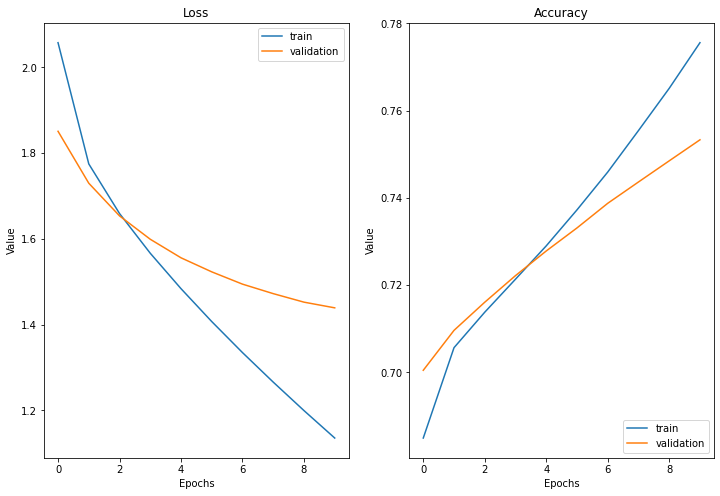

In [136]:
line_plot(result.epoch, result.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

***

<span style="font-size:12pt; line-height:1.5;">
위 그래프를 통해, 5번째 에포크부터 오버 피팅의 모습을 보여주었다.<br>
위 현상을 개선하기 위해, 다음 모델 생성시 학습률을 낮추거나 더 많은 훈련 데이터를 추가해주는것이 좋겠다.
</span>

***

## 8. Model test

***

<span style="font-size:12pt; line-height:1.5;">
학습된 모델로 텍스트를 생성하는 과정이다.<br>
</span>

***

In [91]:
# 3. 텍스트 생성
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    
    # step1. 모델의 입력값이 텐서이므로, 문장을 텐서 구조로 변환.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # step2. 1단어 단위로 생성하기 위한 무한루프 
    while True:
        
        # step2-1. 모델의 예측값으로 단어 생성
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]

        # step2-2. 생성한 단어를 기존 문장 뒤에 결합
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # step2-3. 모델 예측값 == <End> 토큰 : 반복문 종료
        if predict_word.numpy()[0] == end_token: break
            
        # step2-4. 모델 예측값 >= 문장 내 단어 최대 개수 : 반복문 종료
        if test_tensor.shape[1] >= max_len: break

    # step3. word index 값에 맞춰 단어 조합
    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

***

<span style="font-size:12pt; line-height:1.5;">
위 텍스트 생성기 함수를 활용하여 말뭉치 모음집에 있는 단어를 일부 제시하여 20자 이내의 간단한 문장을 생성해보자 한다.<br>
</span>

***

In [104]:
generate_text(model, tokenizer, init_sentence="<start> god", max_len=20)

'<start> god knows you re the only one <end> '

***
<span style="font-size:12pt; line-height:1.5;">
'신은 당신이 유일한 사람이란걸 알고 있다' 라는 명언을 생산했다. 여러분 모두 소중한 사람이다.<br>
이번엔 자신이 누군지 물어보는 텍스트를 생성시켜보았다.
</span>

***

In [112]:
generate_text(model, tokenizer, init_sentence="<start> I am", max_len=20)

'<start> i am a god <end> '

***
<span style="font-size:12pt; line-height:1.5;">
'나는 신이다' 라는 자신감을 나타내었다. 자신감 있는 모습이 보기 좋다.<br>
이번엔 노래 가사에 주로 쓰이는 '사랑'을 주제로 텍스트를 생성해보았다.
</span>

***

In [113]:
generate_text(model, tokenizer, init_sentence="<start> love", max_len=20)

'<start> love is a beautiful thing <end> '

***

<span style="font-size:12pt; line-height:1.5;">
'사랑은 아름다운 것이다.' 라며 사랑에 빠진 모습을 보여주었다. 오래오래 사랑하길.<br>
이번엔 명사가 아닌 부사로 사용되는 'some'이란 단어로 텍스트를 생성시켜 보았다.
</span>

***

In [120]:
generate_text(model, tokenizer, init_sentence="<start> some", max_len=20)

'<start> some people want diamond rings <end> '

***

<span style="font-size:12pt; line-height:1.5;">
'어떤 사람들은 다이아몬드 반지를 원한다' 라며 보석에 대한 사람들의 소망을 말해준다. 필자도 원한다.<br>
마지막으로 단어장에 없는 '아이펠'로 텍스트를 생성하도록 시켜보았다.
</span>

***

In [121]:
generate_text(model, tokenizer, init_sentence="<start> aiffel", max_len=20)

'<start> <unk> <unk> <unk> <unk> <end> '

***

<span style="font-size:12pt; line-height:1.5;">
말뭉치 모음집에 없는 단어는 생성하지 못하는 모습을 보여주었다.
</span>

***